## Overview from Slide-level

### tiles-l1-s256 & feats-l1-s256-mrandom_be-n1000

At step 2, we segmented tissues from WSIs, and generated 256x256 patches at level 1 (which is 1024x1024 at level 0). 

At step 4, we sampled 1000 tiles from each WSI using `random_be` method.

Below gives the summary of it.

| Statistics  | Count       |
| :-----------: | :-----------: |
| Slides         | 1225       |
| Patches        | 3599783        |
| Selected Tiles | 1145836        |
| Avg. Patches per Slide|2938.598 |
| Avg. Tiles per Slide| 935.376 |

In [1]:
import os
import h5py

PATH_PATCH = '/NAS01/Dataset/NLST/PathologySlide/tiles-l1-s256/patches'
PATH_PAT = '/NAS01/Dataset/NLST/Pathology/nlst_path_path2pat.csv'
N = 1000

def sampling_num(n, vals, sample_size):
    assert n == len(vals)
    filtered_vals = [v for v in vals if v > 0]
    
    return min(sample_size, len(filtered_vals))

slide_ids = []
slide_num_patch = []
slide_num_select = []
for slide in os.listdir(PATH_PATCH):
    slide_h5_path = os.path.join(PATH_PATCH, slide)
    if not os.path.isfile(slide_h5_path):
        continue
        
    slide_ids.append(slide.split('.h5')[0])
    with h5py.File(slide_h5_path, 'r') as f:
        coords = f['coords']
        values = f['energy']
        n_coords = len(coords)
        slide_num_patch.append(n_coords)
        slide_num_select.append(sampling_num(n_coords, values, N))

In [2]:
print("From slide-level:")
print("\t#Slides : ", len(slide_ids))
print("\t#Patches: ", sum(slide_num_patch))
print("\t#Tiles  : ", sum(slide_num_select))
print('\n')
print("\tAvg. Patches/Slide: %.3f" % (sum(slide_num_patch) / len(slide_ids)))
print("\tAvg. Tiles/Slide  : %.3f" % (sum(slide_num_select) / len(slide_ids)))

From slide-level:
	#Slides :  1225
	#Patches:  3599783
	#Tiles  :  1145836


	Avg. Patches/Slide: 2938.598
	Avg. Tiles/Slide  : 935.376


Read data of mapping from `slide_id` to `patient_id`

In [4]:
import pandas as pd

ref = pd.read_csv(PATH_PAT)
patient_ids = [list(ref.loc[ref['pathology_id'] == sid, 'patient_id'])[0] for sid in slide_ids]

Inspect slides whose **number of selected tiles is less than 100**

In [5]:
th = 100
for i, slide in enumerate(slide_ids):
    if slide_num_patch[i] < th:
        print(patient_ids[i], slide, slide_num_patch[i])

116477 10119 71
133530 NLSI0000122 71
118035 10496 34
113598 9775 29
101275 11302 95


In [6]:
slide_num_select_less_than_N = [i for i in slide_num_select if i < N]
slide_num_select_equal_N = [i for i in slide_num_select if i >= N]

print("From slide-level:")
print("\tNumber of selected tiles < %d" % N)
print("\t\tRatio = %.2f%%, #Count = %d" % (100.0*len(slide_num_select_less_than_N)/len(slide_ids), len(slide_num_select_less_than_N)))

print("\tNumber of selected tiles = %d" % N)
print("\t\tRatio = %.2f%%, #Count = %d" % (100.0*len(slide_num_select_equal_N)/len(slide_ids), len(slide_num_select_equal_N)))

From slide-level:
	Number of selected tiles < 1000
		Ratio = 18.53%, #Count = 227
	Number of selected tiles = 1000
		Ratio = 81.47%, #Count = 998


### Plotting the distribution of the number of patches and tiles

<AxesSubplot:ylabel='Count'>

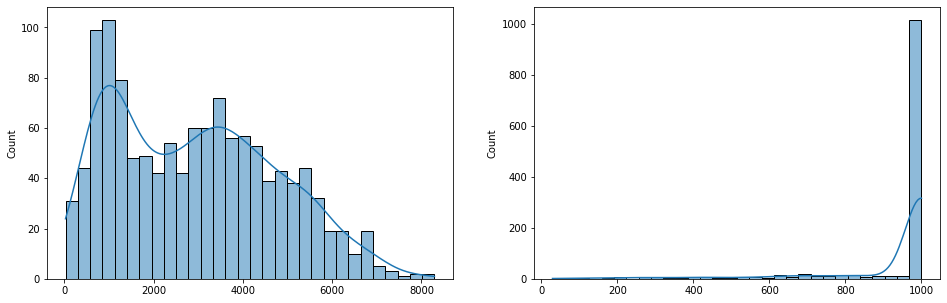

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

fig, axes = plt.subplots(1,2,figsize=(16, 5))
sns.histplot(slide_num_patch, bins=30, ax=axes[0], kde=True, label='Number of Patches')
sns.histplot(slide_num_select, bins=30, ax=axes[1], kde=True, label='Number of Sampled Patches')

## Overview from Patient-level



### tiles-l1-s256 & feats-l1-s256-mrandom_be-n1000

Below gives the summary of it from patient-level.

| Statistics  | Count       |
| :-----------: | :-----------: |
| Patients         | 449       |
| Slides         | 1225       |
| Avg. Slides per Patient  | 2.728       |
| Patches        | 3599783        |
| Selected Tiles | 1145836        |
| Avg. Patches per Patient|8017.334 |
| Avg. Tiles per Patient| 2551.973 |

In [9]:
pids = set(patient_ids)

num_slides = []
num_patches = []
num_tiles = []
for p in pids:
    idxs = [i for i in range(len(patient_ids)) if patient_ids[i] == p]
    num_slides.append(len(idxs))
    num_patches.append(sum([slide_num_patch[_] for _ in idxs]))
    num_tiles.append(sum([slide_num_select[_] for _ in idxs]))

print("From patient-level")
print("\t#Patients:", len(pids))
print("\t#Slides  :", sum(num_slides))
print("\t#Patches :", sum(num_patches))
print("\t#Tiles   :", sum(num_tiles))

print("Avg. Slides/Patient : %.3f " % (sum(num_slides) / len(pids)))
print("Avg. Patches/Patient: %.3f" % (sum(num_patches) / len(pids)))
print("Avg. Tiles/Patient  : %.3f" % (sum(num_tiles) / len(pids)))

From patient-level
	#Patients: 449
	#Slides  : 1225
	#Patches : 3599783
	#Tiles   : 1145836
Avg. Slides/Patient : 2.728 
Avg. Patches/Patient: 8017.334
Avg. Tiles/Patient  : 2551.973


In [10]:
num_select_less_than_N = [i for i in num_tiles if i < N]
num_select_equal_N = [i for i in num_tiles if i >= N]

print("From patient-level:")
print("Number of selected tiles < %d" % N)
print("\tRatio = %.2f%%, #Count = %d" % (100.0*len(num_select_less_than_N)/len(pids), len(num_select_less_than_N)))

print("Number of selected tiles = %d" % N)
print("\tRatio = %.2f%%, #Count = %d" % (100.0*len(num_select_equal_N)/len(pids), len(num_select_equal_N)))

From patient-level:
Number of selected tiles < 1000
	Ratio = 7.80%, #Count = 35
Number of selected tiles = 1000
	Ratio = 92.20%, #Count = 414


### Plotting the distribution of the number of patches and tiles

<AxesSubplot:ylabel='Count'>

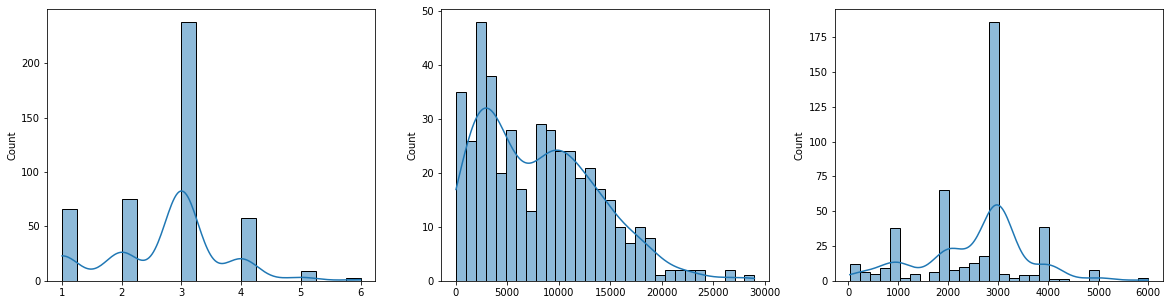

In [12]:
fig, axes = plt.subplots(1,3,figsize=(20, 5))
sns.histplot(num_slides, ax=axes[0], kde=True, label='Number of Slides')
sns.histplot(num_patches, bins=30, ax=axes[1], kde=True, label='Number of Patches')
sns.histplot(num_tiles, bins=30, ax=axes[2], kde=True, label='Number of Sampled Patches')